# Generate ScatterPlots of Datasets

Here, we show the first two dimensions of each dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from collections import defaultdict
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from hyppo.conditional import ConditionalDcorr
from joblib import Parallel, delayed
from scipy.special import expit
from sklearn.datasets import (
    make_blobs,
    make_classification,
    make_sparse_spd_matrix,
    make_spd_matrix,
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sktree import HonestForestClassifier, RandomForestClassifier, RandomForestRegressor
from sktree.datasets.multiview import make_gaussian_mixture, make_joint_factor_model
from sktree.stats import (
    FeatureImportanceForestClassifier,
    FeatureImportanceForestRegressor,
    PermutationForestRegressor,
    PermutationTest,
)
from sktree.stats.utils import (
    METRIC_FUNCTIONS,
    POSITIVE_METRICS,
    POSTERIOR_FUNCTIONS,
    REGRESSOR_METRICS,
    _compute_null_distribution_coleman,
    _non_nan_samples,
)
from sktree.tree import DecisionTreeClassifier, MultiViewDecisionTreeClassifier

seed = 12345
rng = np.random.default_rng(seed)

In [4]:
sim_type = "direct-indirect"
idx = 0

In [6]:
if sim_type == "confounder":
    npy_data = np.load(
        f"/Users/adam2392/Desktop/cancer/data/confounder/confounder_{idx}.npz"
    )
elif sim_type == "collider":
    npy_data = np.load(f"/Users/adam2392/Desktop/cancer/collider/collider_{idx}.npz")
elif sim_type == "mediator":
    npy_data = np.load(f"/Users/adam2392/Desktop/cancer/mediator/mediator_{idx}.npz")
elif sim_type == "direct-indirect":
    npy_data = np.load(
        f"/Users/adam2392/Desktop/cancer/data/direct-indirect/direct-indirect_{idx}.npz"
    )
elif sim_type == "independent":
    npy_data = np.load(
        f"/Users/adam2392/Desktop/cancer/data/independent/independent_{idx}.npz"
    )
elif sim_type == "log_collider":
    npy_data = np.load(
        f"/Users/adam2392/Desktop/cancer/data/log_collider/log_collider_{idx}.npz"
    )

X = npy_data["X"]
y = npy_data["y"]

In [7]:
print(X.shape)
print(y.shape)

(2048, 4196)
(2048,)


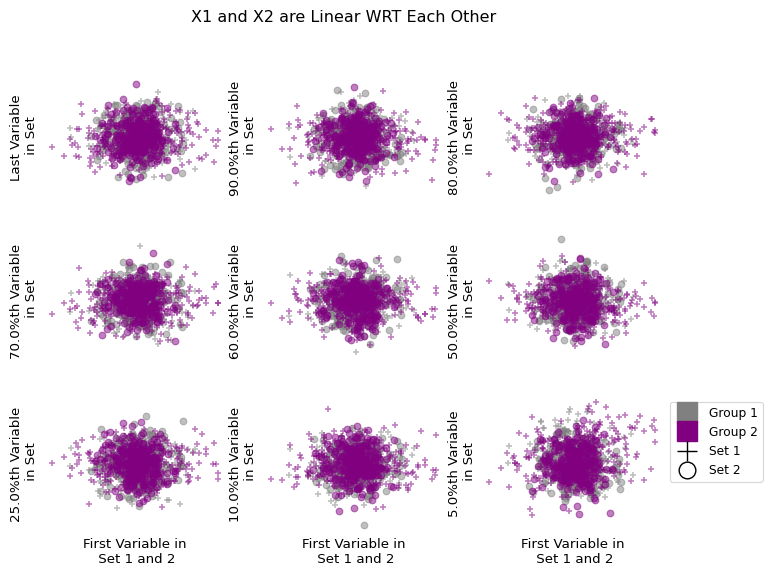

In [34]:
sns.set_context("paper", font_scale=1.0)
fig, axs = plt.subplots(3, 3, sharey=True, sharex=True, squeeze=True, figsize=(8, 6))
axs = axs.flatten()
colors = ["gray", "purple"]

n_samples = 256
ifeature_list = [-1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 0.9, 0.95]

# for idx, ifeature in enumerate([-1, 0.1, 0.2, 0.3, 0.4, 0.5]):
idx = 0
for i in range(3):
    for j in range(3):
        ax = axs[idx]

        ifeature = ifeature_list[idx]

        if ifeature > 0:
            X1_idx = 100 - int(100 * ifeature)
            X2_idx = X.shape[1] - int(X.shape[1] * ifeature)
        else:
            X1_idx = 100 + ifeature
            X2_idx = X.shape[1] + ifeature

        for iclass in np.unique(y.astype(int)):
            y_samples = np.argwhere(y == iclass)
            ax.scatter(
                X[y_samples[:n_samples], 0],
                X[y_samples[:n_samples], X1_idx],
                color=colors[iclass],
                marker="+",
                label="Set 1",
                alpha=0.5,
            )
            ax.scatter(
                X[y_samples[:n_samples], 32],
                X[y_samples[:n_samples], X2_idx],
                color=colors[iclass],
                marker="o",
                label="Set 2",
                alpha=0.5,
            )

        # ax.axis("off")
        # ax.grid(False)
        ax.set_frame_on(False)
        ax.set_xticks([])
        ax.set_yticks([])
        if ifeature == -1:
            ax.set(ylabel='Last Variable\n in Set')
        else:
            ax.set(ylabel=f"{np.round(100*(1. - ifeature),2)}%th Variable\n in Set")
        # if j == 0:
        #     ax.set(
        #         # xlabel="First Variable in\n Set 1 and 2",
        #         ylabel="Last Variable in\n Set 1 and 2",
        #     )
        if i == 2:
            ax.set(
                xlabel="First Variable in\n Set 1 and 2",
                # ylabel="Last Variable in\n Set 1 and 2",
            )
        idx += 1


# Create custom legend handles and labels
class1_patch = plt.Line2D(
    [0], [0], linestyle="none", marker="s", color=colors[0], label="Group 1"
)
class2_patch = plt.Line2D(
    [0], [0], linestyle="none", marker="s", color=colors[1], label="Group 2"
)
set1_line = plt.Line2D(
    [0], [0], linestyle="none", marker="+", color="black", label="Set 1"
)
set2_line = plt.Line2D(
    [0],
    [0],
    linestyle="none",
    marker="o",
    markersize=4,
    fillstyle="none",
    color="black",
    label="Set 2",
)

# Create the legend
ax.legend(
    handles=[class1_patch, class2_patch, set1_line, set2_line],
    loc="best",
    markerscale=3.0,
)
fig.suptitle('X1 and X2 are Linear WRT Each Other')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()